# 군집화

In [1]:
# # 한글폰트
# !pip install koreanize_matplotlib
# # 군집화
# !pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

## 데이터 로드

In [5]:
rfm = pd.read_csv('rfm.csv', index_col="CustomerID")
rfm.shape

(4338, 9)

In [7]:
rfm_cluster = rfm.iloc[:,:3]
rfm_cluster.head(2)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.6
12347.0,2,182,4310.0


In [8]:
rfm_cluster.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.583679,90.523513,2009.852304
std,100.019339,225.507058,8622.507371
min,1.000000,1.000000,2.900000
25%,18.000000,17.000000,306.452500
50%,51.000000,41.000000,668.495000
75%,142.750000,98.000000,1659.132500
max,374.000000,7676.000000,280206.020000


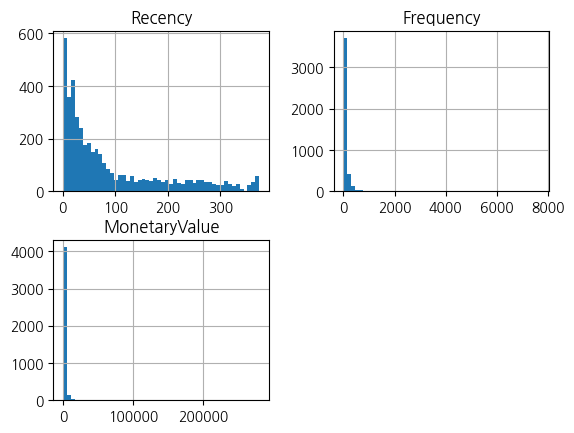

In [11]:
rfm_cluster.hist(bins = 50);

## 로그 변환
- 머신러닝 모델이 잘 이해할 수 있도록 정규 분포 형태로 변환

In [14]:
rfm_cluster_log = np.log1p(rfm_cluster) # 0을 방지
rfm_cluster_log.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,3.831803,3.728972,6.586102
std,1.339608,1.245411,1.258222
min,0.693147,0.693147,1.360977
25%,2.944439,2.890372,5.728321
50%,3.951244,3.737670,6.506524
75%,4.968071,4.595120,7.414652
max,5.926926,8.945984,12.543284


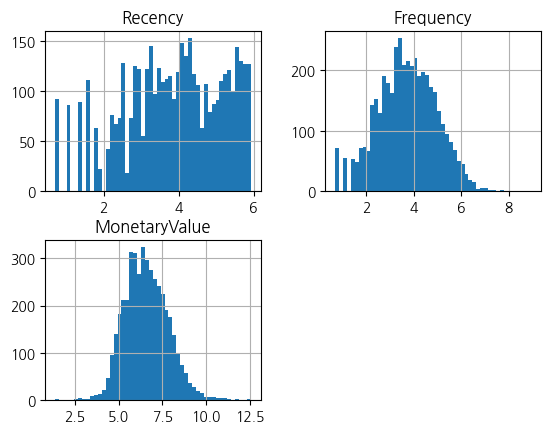

In [15]:
# hist
rfm_cluster_log.hist(bins = 50);

## 스케일 조정

In [19]:
# StandardScaler => 평균을 빼고 표준편차로 나눈다. (표준편차)
# MinMaxScaler => 최솟값 0, 최댓값 1
# RobustScaler => 중간값 0, IQR값으로 나눠줌
# 회귀, KNN, K-means 등의 거리 기반 알고리즘에 사용하면 좀 더 나은 성능을 보인다.
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

mm = MinMaxScaler()
X = mm.fit_transform(rfm_cluster_log)

In [20]:
pd.DataFrame(X).describe().round(2)

,0,1,2
count,4338.00,4338.00,4338.00
mean,0.60,0.37,0.47
std,0.26,0.15,0.11
min,0.00,0.00,0.00
25%,0.43,0.27,0.39
50%,0.62,0.37,0.46
75%,0.82,0.47,0.54
max,1.00,1.00,1.00


## StandardScaler

In [22]:
ss = StandardScaler()
X = ss.fit_transform(rfm_cluster_log)
X = pd.DataFrame(X, columns=rfm_cluster_log.columns)

In [24]:
X.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4338.00,4338.00,4338.00
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.34,-2.44,-4.15
25%,-0.66,-0.67,-0.68
50%,0.09,0.01,-0.06
75%,0.85,0.70,0.66
max,1.56,4.19,4.74


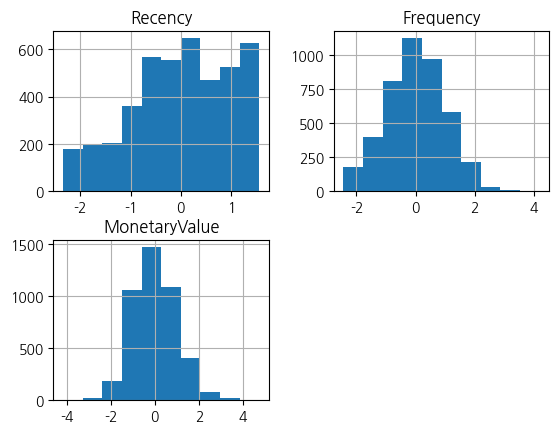

In [26]:
X.hist();

# KMeans

In [34]:
# cluster.KMeans, metrics.silhouette_score 불러오기
# rfm_norm 값을 학습하고
# elbow 값을 보기위해 inertia_ 값을 리스트로 만듭니다.
# silhouette_score(X, kmeans.labels_) 값도 리스트로 만듭니다.


# KMeans(
#     n_clusters=8,
#     *,
#     init='k-means++',
#     n_init="auto",
#     max_iter=300,
#     tol=0.0001,
#     verbose=0,
#     random_state=None,
#     copy_x=True,
#     algorithm='lloyd',
# )

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)
kmeans.cluster_centers_, kmeans.inertia_

(array([[-0.36897607, -0.66984552, -0.80897528],
        [ 0.42384092,  0.20266805,  0.10666179],
        [-1.50089666,  1.58646594,  1.71175944],
        [-0.12920724,  0.99451208,  0.98845587],
        [ 1.14140717, -0.49988931, -0.68458615],
        [-1.19169688,  0.38878091,  0.27673355],
        [ 1.00027544, -1.59759399, -1.48142454],
        [ 0.51375114, -1.3675099 ,  0.25709927]]),
 2784.2214944948983)

In [32]:
kmeans.cluster_centers_.shape

(8, 3)

## Within-Cluster Sum of Square

In [40]:
inertia = []
silhouettes = []
range_n_clusters = range(2, 21)

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels = kmeans.labels_))

## Elbow Method
- Number of Clusters
- Within-Cluster Sum of Square

<Axes: >

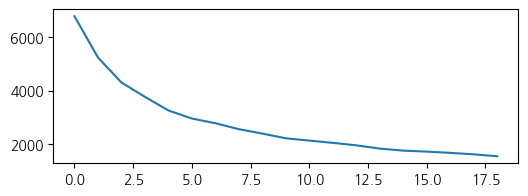

In [39]:
pd.Series(inertia).plot(figsize=(6, 2))

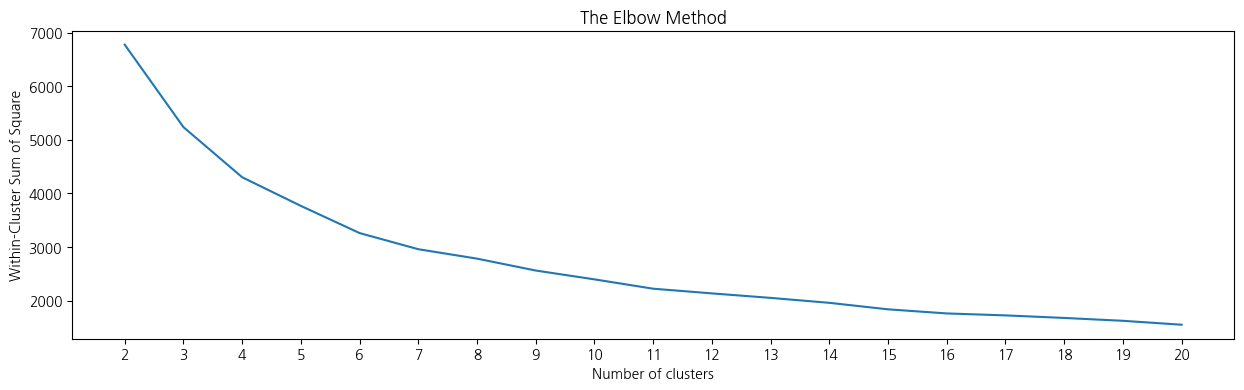

In [41]:
plt.figure(figsize=(15,4))
plt.plot(range_n_clusters, inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range_n_clusters)
plt.show()

## Silhouette Score


* 실루엣 계수(Silhouette coefficient)는 클러스터링(군집화)의 성능을 평가하기 위한 지표 중 하나
* 각 데이터 포인트의 실루엣 계수는 해당 데이터 포인트가 얼마나 잘 클러스터링되었는지를 나타냄
* 정답 레이블을 모르는 경우 모델 자체를 사용하여 평가를 수행
* 실루엣 계수(sklearn.metrics.silhouette_score)는 이러한 평가의 한 예
* 실루엣 계수는 각 샘플에 대해 정의되며 두 가지 점수로 구성
    * a : 같은 클러스터 내의 다른 데이터 포인트들과의 평균 거리 (즉, 동일 클러스터 내에서의 응집도)
    * b : 가장 가까운 클러스터에서의 평균 거리 (즉, 가장 가까운 다른 클러스터와의 분리도)
    * 단일 샘플에 대한 실루엣 계수 s 는 다음과 같이 주어집니다.
        * `s = (b-a)/max(a,b)`

* 좋은 군집화가 되기 위한 기준 조건
    * 전체 실루엣 계수의 평균값, 즉 사이킷런의 silhouette_score() 값은 -1~1 사이의 값을 가지며, 1에 가까울수록 좋음
    * 값이 1에 가까울수록: 해당 데이터 포인트가 자신의 클러스터 내에서 잘 클러스터링 되었으며 다른 클러스터와는 잘 분리되어 있다는 것을 의미
    * 값이 0에 가까울수록: 해당 데이터 포인트가 클러스터 경계에 위치해 있다는 것을 의미
    * 값이 -1에 가까울수록: 해당 데이터 포인트가 잘못된 클러스터에 할당되었음을 나타냄
    * 하지만 전체 실루엣 계수의 평균값과 더불어 개별 군집의 평균값의 편차가 크지 않아야함
    * 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요
    * 만약 전체 실루엣 계수의 평균값은 높지만, 특정 군집의 실루엣 계수 평균값만 유난히 높고 다른 군집들의 실루엣 계수 평균값은 낮으면 좋은 군집화 조건이 아님
    * 일반적으로 이 값이 높을수록 군집화가 어느 정도 잘 됐다고 판단할 수 있지만 무조건 이 값이 높다고 해서 군집화가 잘 됐다고 판단할 수는 없음

* https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

* `silhouette_samples(X, labels, metric='euclidean', **kwds)` : X feature 데이터 세트와 각 feature데이터 세트가 속한 군집 레이블 값인 labels데이터를 입력해주면 각 데이터 포인트의 실루엣 계수를 계산해 반환
* `silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds)`:
    * 인자로 X feature데이터 세트와 각 feature 데이터 세트가 속한 레이블 값인 labels데이터를 입력해주면 전체 데이터의 실루엣 계수 값을 평균해 반환
    * np.mean(silhouette_samples())

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score


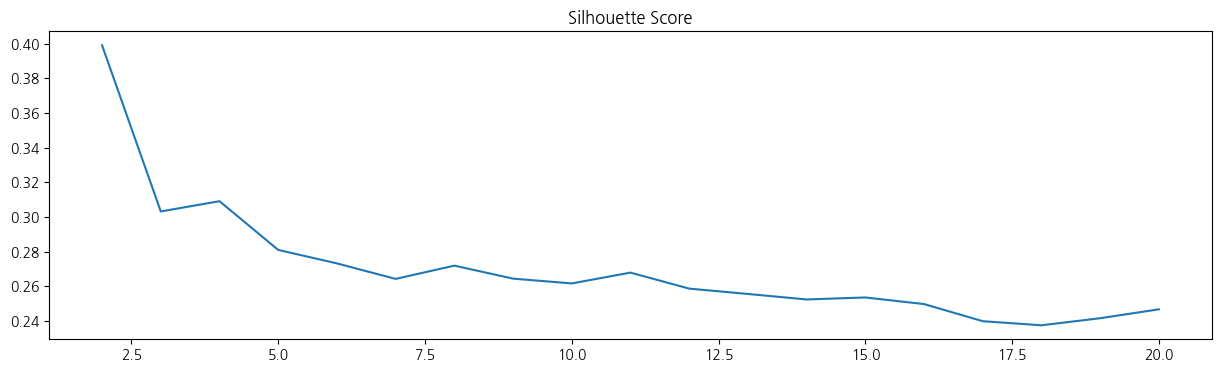

In [42]:
plt.figure(figsize=(15, 4))
plt.title('Silhouette Score')
plt.plot(range_n_clusters, silhouettes)
plt.show()

## KElbowVisualizer


- 실루엣 계수는 데이터 세트에 대한 실측을 알 수 없는 경우에 사용되며 모델에서 계산한 클러스터의 밀도를 계산합니다. 
- 점수는 각 샘플에 대한 실루엣 계수를 평균화하여 계산되며, 최대값으로 정규화된 각 샘플에 대한 평균 클러스터 내 거리와 평균 가장 가까운 클러스터 거리 간의 차이로 계산됩니다. 
- 이것은 1에서 -1 사이의 점수를 생성합니다. 여기서 1은 고밀도 클러스터이고 -1은 완전히 잘못된 클러스터링입니다.

실루엣 시각화 도우미는 클러스터별로 각 샘플에 대한 실루엣 계수를 표시하여 어떤 클러스터가 조밀하고 그렇지 않은지를 시각화합니다. 이는 클러스터 불균형을 결정하거나 다음 값을 선택하는 데 특히 유용합니다.

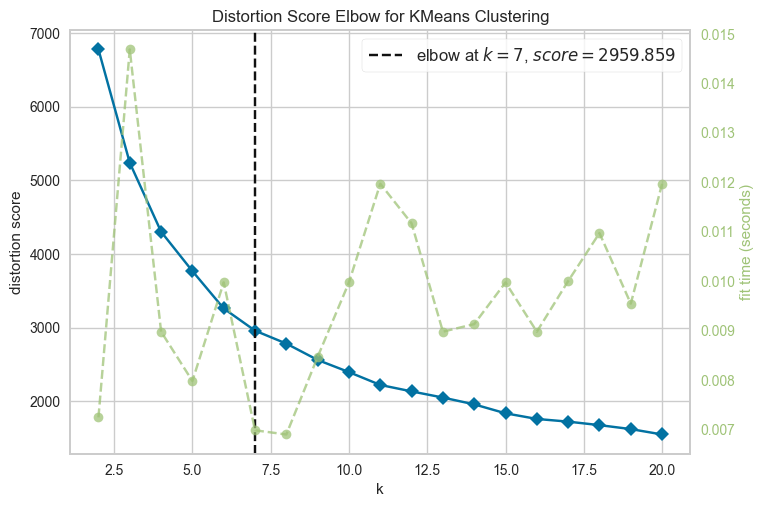

In [44]:
# !pip install yellowbrick
# yellowbrick.cluster 에서 KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

KEV = KElbowVisualizer(kmeans, k = 20)
KEV.fit(X)
KEV.show();

## KMeans n_clusters 값을 정해 학습하기

In [45]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [46]:
kmeans.labels_

array([1, 2, 1, ..., 1, 2, 1])

In [47]:
kmeans.cluster_centers_

array([[ 0.79690802, -0.97740351, -0.91891438],
       [-0.0424308 ,  0.14386538,  0.07979015],
       [-1.09758989,  1.17899544,  1.20943507]])

In [48]:
pd.Series(kmeans.labels_).value_counts()

1    1838
0    1496
2    1004
Name: count, dtype: int64

## 실루엣 분석 시각화

In [50]:
# silhouette_score 구하기
# silhouette_avg
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

0.3031987778341889

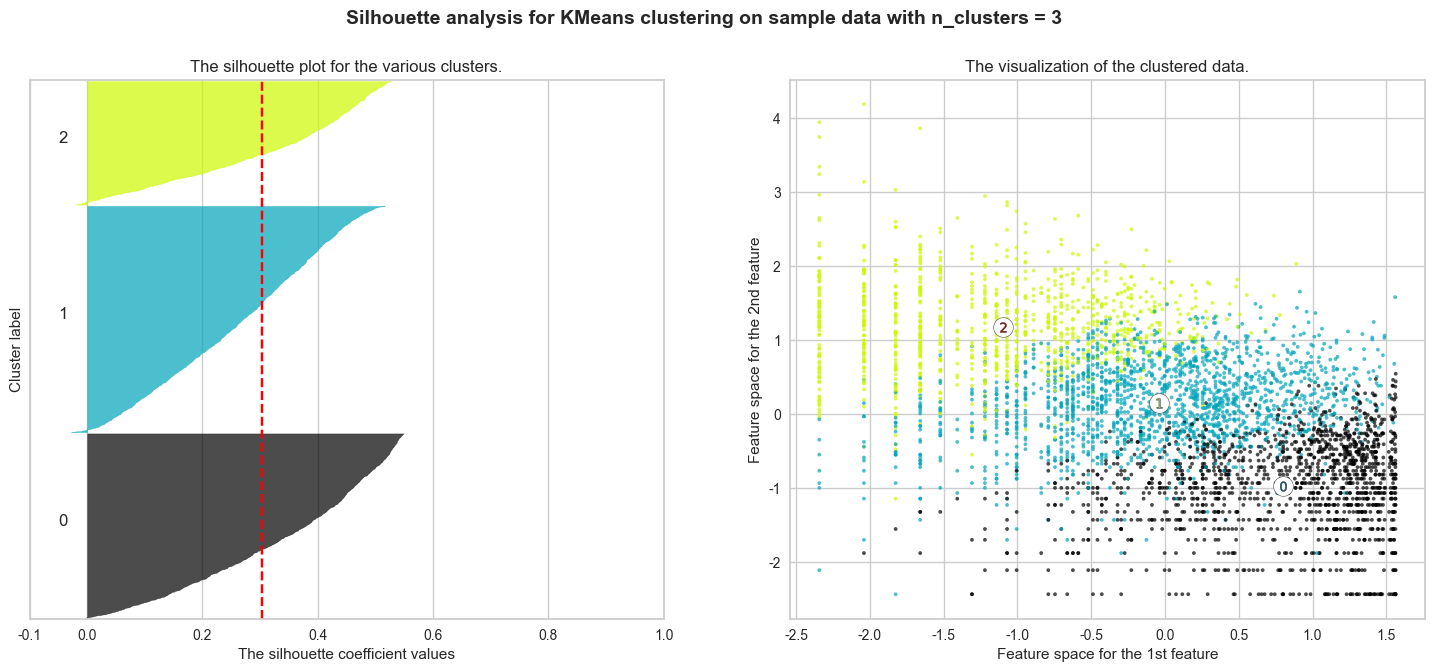

In [51]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

## RFM_class 와 군집결과 교차표

In [52]:
rfm["Cluster"] = kmeans.labels_
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver,1
12347.0,2,182,4310.00,5,5,5,555,15,platinum,2
12348.0,75,31,1797.24,2,3,4,234,9,gold,1
12349.0,19,73,1757.55,4,4,4,444,12,platinum,1
12350.0,310,17,334.40,1,2,2,122,5,silver,0
...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,silver,0
18281.0,181,7,80.82,1,1,1,111,3,silver,0
18282.0,8,12,178.05,5,1,1,511,7,silver,1


In [53]:
# RFM_class 와 Cluster 교차표
pd.crosstab(rfm["RFM_class"], rfm["Cluster"])

Cluster,0,1,2
RFM_class,,,
gold,15,1374,20
platinum,0,277,984
silver,1481,187,0


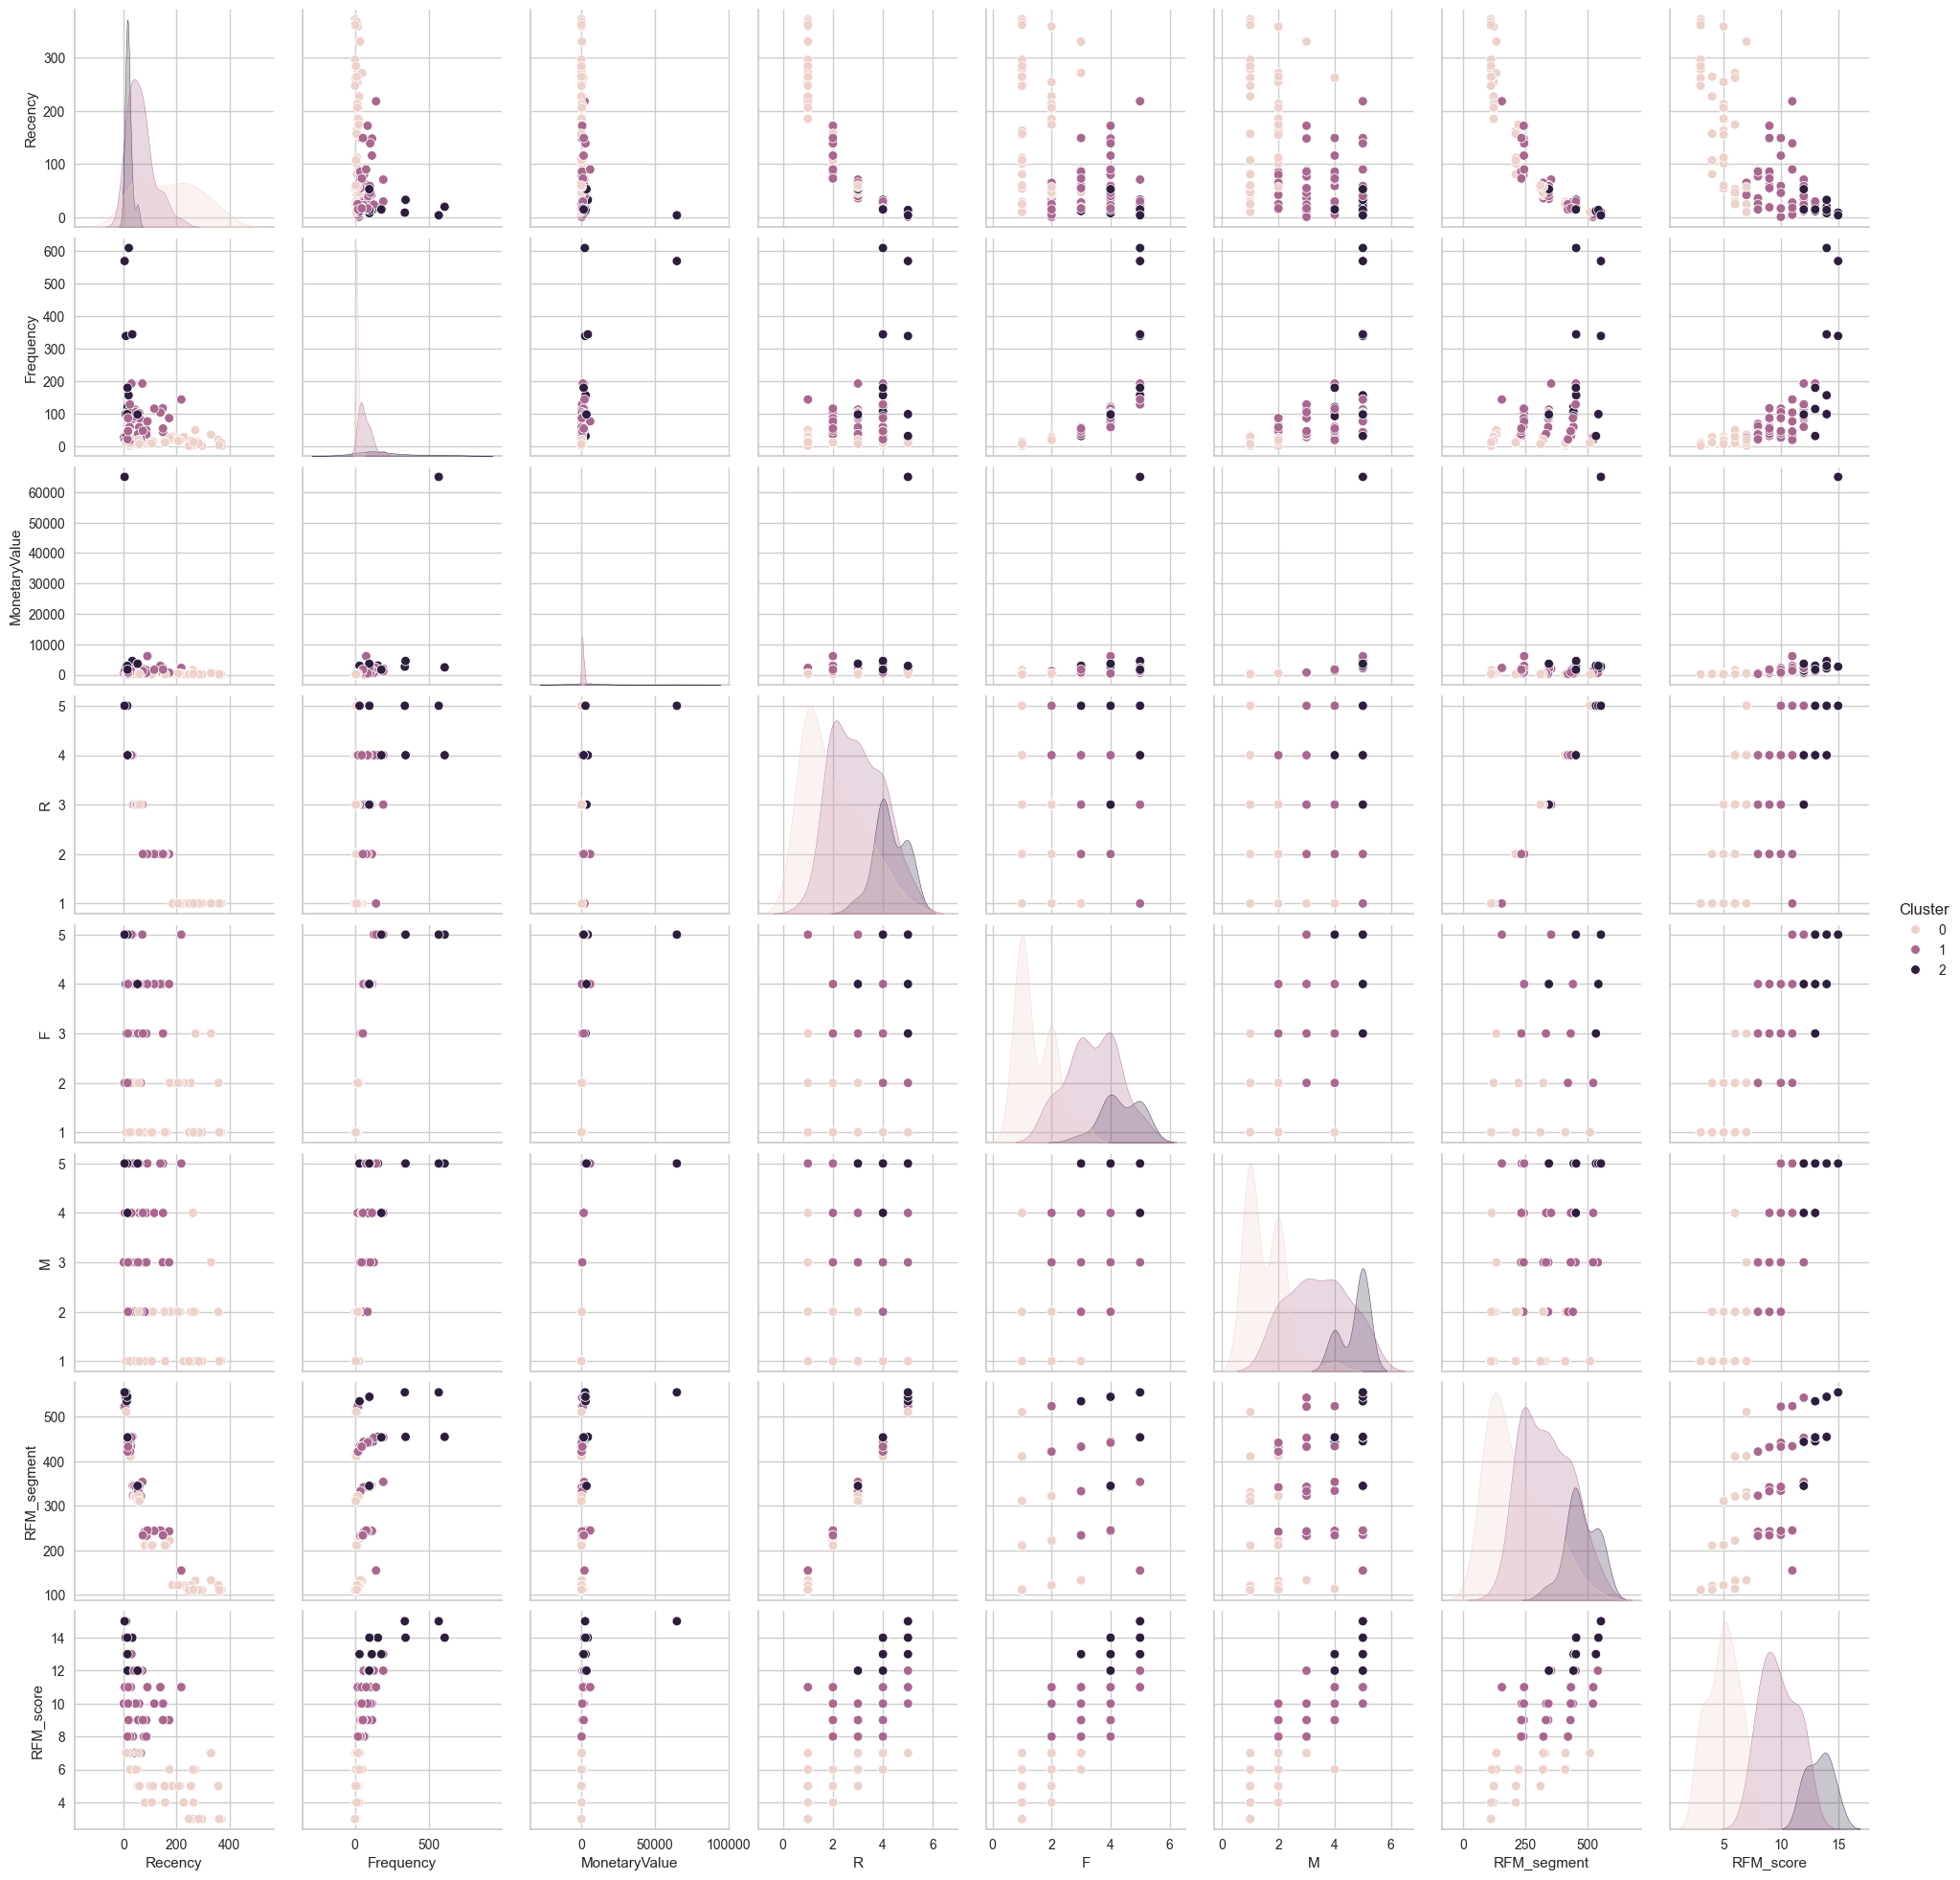

In [54]:
# pairplot() 오래 걸리기 때문에 rfm.sample() 일부만 그려보기)
sns.pairplot(data=rfm.sample(100), hue="Cluster")

- 기존 RFM 분석에서 사용했던 상대평가(qcut) 방법으로 고객을 군집화 할 수도 있고 변수가 엄청 많다면 qcut 으로 군집화 할 때 전처리 등이 까다로울 수도 있습니다. 
- 예를 들어 설문조사, 사용자 행동정보, 인구통계학적 정보 등의 다양한 변수를 사용하고자 할 때 군집화 기법을 사용하면 비교적 간단하게 고객을 군집화 할 수도 있습니다.